In [173]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
import numpy as np
import math

In [174]:
N=10


In [175]:

array=np.random.randint(N, size=10)
N=len(array)
print(array)

[2 9 7 1 7 5 9 4 6 4]


In [176]:
# shuffle the array 
np.random.shuffle(array)

In [177]:
RootN=np.sqrt(N)

# choose first rootN elements
marked = array[:int(RootN)]
marked

array([6, 7, 4])

In [179]:
if(len(set(marked))!=len(marked)):
    print("Error: Marked elements are not unique, found duplicates")

In [180]:
remaining = array[int(RootN):]
remaining


array([1, 5, 4, 9, 9, 2, 7])

In [181]:
solution_idx=[]
for i in marked:
    for j in range(len(remaining)):
        if i==remaining[j]:
            solution_idx.append(j)

solution_idx

[6, 2]

In [182]:
# remaining=[1,2,3,4]
# solution_idx=[2]
T=len(remaining)
# log of T
logT=math.ceil(np.log2(T))
logT

3

In [194]:
def grover_iterator(oracle,N):
    qc=QuantumCircuit(N)
    qc.append(oracle,range(N))
    # qc.barrier()
    qc.h(range(N))
    qc.x(range(N))
    qc.h(N-1)
    qc.mcx(list(range(N-1)),N-1)
    qc.h(N-1)
    qc.barrier()
    qc.x(range(N))
    qc.h(range(N))
    qc.barrier()
    return qc



In [184]:
def A(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    qc.barrier()
    return qc

In [213]:
# Create oracle for the Grover's algorithm
def oracle(n, solution_indices):
    oracle = QuantumCircuit(n)
    # print(n)
    oracle.barrier()
    for idx in solution_indices:
        # cnot on binary representation of idx
        control_list=[]
        cl=[]
        target=n-1
        ele=idx
        while(ele>0):
            cl.append(ele%2)
            ele=ele//2
        # cl.reverse()
        # print(cl)
        
        for i in range(len(cl)):
            if(cl[i]==1):
                control_list.append(i)
        
        control_list=[target-1-i for i in control_list]
        # print(idx,"control: ",control_list)
        
        oracle.h(target)
        oracle.mcx(control_list,target) 
        oracle.h(target)

    oracle.barrier()
    print("oracle circuit:")
    print(oracle)
    return oracle

oracle_circuit = oracle(logT+1, solution_idx)
grover=grover_iterator(oracle_circuit,logT+1)



oracle circuit:
      ░                                ░ 
q_0: ─░────────■───────────────────────░─
      ░        │                       ░ 
q_1: ─░────────■──────────────■────────░─
      ░        │              │        ░ 
q_2: ─░────────┼──────────────┼────────░─
      ░ ┌───┐┌─┴─┐┌───┐┌───┐┌─┴─┐┌───┐ ░ 
q_3: ─░─┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├─░─
      ░ └───┘└───┘└───┘└───┘└───┘└───┘ ░ 


In [214]:
grover.draw()

┌──────────────┐┌───┐┌───┐                ░ ┌───┐┌───┐ ░ 
q_0: ┤0             ├┤ H ├┤ X ├───────■────────░─┤ X ├┤ H ├─░─
     │              │├───┤├───┤       │        ░ ├───┤├───┤ ░ 
q_1: ┤1             ├┤ H ├┤ X ├───────■────────░─┤ X ├┤ H ├─░─
     │  circuit-812 │├───┤├───┤       │        ░ ├───┤├───┤ ░ 
q_2: ┤2             ├┤ H ├┤ X ├───────■────────░─┤ X ├┤ H ├─░─
     │              │├───┤├───┤┌───┐┌─┴─┐┌───┐ ░ ├───┤├───┤ ░ 
q_3: ┤3             ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░─┤ X ├┤ H ├─░─
     └──────────────┘└───┘└───┘└───┘└───┘└───┘ ░ └───┘└───┘ ░

In [215]:
# T=logT
circuit=QuantumCircuit(logT+1, logT)
A_circuit= A(logT+1)
circuit.append(A_circuit, range(logT+1))

circuit.append(grover, range(logT+1))
# measurement
circuit.measure(range(logT), range(logT))
circuit.draw()


┌──────────────┐┌──────────────┐┌─┐      
q_0: ┤0             ├┤0             ├┤M├──────
     │              ││              │└╥┘┌─┐   
q_1: ┤1             ├┤1             ├─╫─┤M├───
     │  circuit-817 ││  circuit-813 │ ║ └╥┘┌─┐
q_2: ┤2             ├┤2             ├─╫──╫─┤M├
     │              ││              │ ║  ║ └╥┘
q_3: ┤3             ├┤3             ├─╫──╫──╫─
     └──────────────┘└──────────────┘ ║  ║  ║ 
c: 3/═════════════════════════════════╩══╩══╩═
                                      0  1  2

C:\Users\acer\AppData\Local\Temp\ipykernel_16908\1170834693.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = qasm_simulator.run(qobj).result()


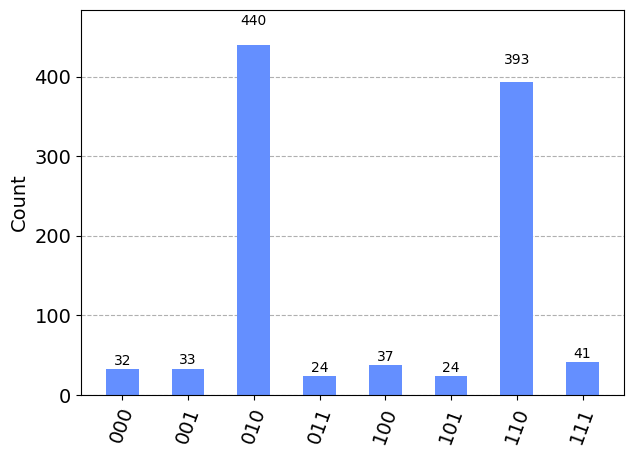

In [216]:

# run the circuit
qasm_simulator = Aer.get_backend("qasm_simulator")
transpiled_circuit = transpile(circuit, qasm_simulator)
qobj = assemble(transpiled_circuit)
result = qasm_simulator.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [217]:
qc=QuantumCircuit(3)

qc.h(range(3))
# qc.cz(0,2)
qc.cz(1,2)
qc.h(range(3))
qc.x(range(3))
qc.h(2)
qc.mct([0,1],2)
qc.h(2)
qc.x(range(3))
qc.h(range(3))

qc.measure_all()

qc.draw()


C:\Users\acer\AppData\Local\Temp\ipykernel_16908\1262288091.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct([0,1],2)


┌───┐┌───┐┌───┐               ┌───┐┌───┐      ░ ┌─┐      
   q_0: ┤ H ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────░─┤M├──────
        ├───┤└───┘├───┤┌───┐       │  ├───┤├───┤      ░ └╥┘┌─┐   
   q_1: ┤ H ├──■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├───
        ├───┤  │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├──■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
        └───┘     └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                         0  1  2

C:\Users\acer\AppData\Local\Temp\ipykernel_16908\3649915204.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = qasm_simulator.run(qobj).result()


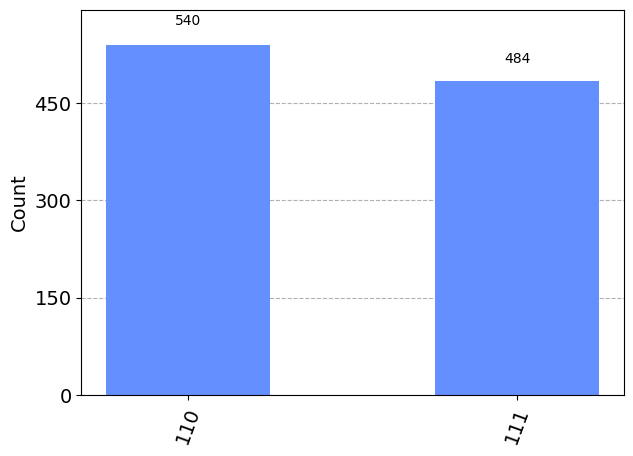

In [218]:
#  run
qasm_simulator = Aer.get_backend("qasm_simulator")
transpiled_circuit = transpile(qc, qasm_simulator)
qobj = assemble(transpiled_circuit)
result = qasm_simulator.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)